In [ ]:
import torch
from sac_learn_cartpole_with_hyperplanes_actor import Actor
from gymnasium.envs.registration import register
from envs.cartpole_pret_gymnasium_hyperparamactions import CartPoleEnvParamActions
register(
    id="customEnvs/CartPoleEnvParamActions",
    entry_point="envs.cartpole_pret_gymnasium_hyperparamactions:CartPoleEnvParamActions",
)
#RL-DH/envs/cartpole_pret_gymnasium.py

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
            print(env.metadata.get("render_fps", None))
        else:
            env = gym.make(env_id)
        from gymnasium.wrappers.time_limit import TimeLimit
        env = TimeLimit(env, 500)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk

import gymnasium as gym
import numpy as np
from gymnasium.wrappers.time_limit import TimeLimit
envs = gym.vector.SyncVectorEnv([make_env("customEnvs/CartPoleEnvParamActions", 0, 0, False, "run_name")])
actor = Actor(envs)

# Load the model's state_dict (parameters)
actor.load_state_dict(torch.load('/home/artur/Schreibtisch/DiscriminatingHyperplaneFork/discriminating-hyperplane/RL-DH/videos/customEnvs/actor_model.pth'))


/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment customEnvs/CartPoleEnvParamActions already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/tmp/ipykernel_11667/797145037.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

RuntimeError: Error(s) in loading state_dict for Actor:
	Missing key(s) in state_dict: "action_scale", "action_bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc_mean.weight", "fc_mean.bias", "fc_logstd.weight", "fc_logstd.bias". 
	Unexpected key(s) in state_dict: "actor_logstd", "critic.0.weight", "critic.0.bias", "critic.2.weight", "critic.2.bias", "critic.4.weight", "critic.4.bias", "actor_mean.0.weight", "actor_mean.0.bias", "actor_mean.2.weight", "actor_mean.2.bias", "actor_mean.4.weight", "actor_mean.4.bias". 

In [58]:
obs = torch.Tensor([[1,0,0.4,0]])
actions, var, mean = actor.get_action(obs)
actions = actions.detach().cpu().numpy()
print(mean)
print(var)
print(actions)

tensor([[ 0.2806, -0.0307]], grad_fn=<AddBackward0>)
tensor([[6.7388]], grad_fn=<SumBackward1>)
[[ 1.         -0.02950403]]


-3.5999999999999996
-0.6283185307179586
-3.5999999999999996
-0.4886921905584123
-3.5999999999999996
-0.34906585039886595
-3.5999999999999996
-0.20943951023931962
-3.5999999999999996
-0.06981317007977328
-3.5999999999999996
0.06981317007977306
-3.5999999999999996
0.2094395102393194
-3.5999999999999996
0.34906585039886573
-3.5999999999999996
0.48869219055841207
-3.1999999999999997
-0.6283185307179586
-3.1999999999999997
-0.4886921905584123
-3.1999999999999997
-0.34906585039886595
-3.1999999999999997
-0.20943951023931962
-3.1999999999999997
-0.06981317007977328
-3.1999999999999997
0.06981317007977306
-3.1999999999999997
0.2094395102393194
-3.1999999999999997
0.34906585039886573
-3.1999999999999997
0.48869219055841207
-2.8
-0.6283185307179586
-2.8
-0.4886921905584123
-2.8
-0.34906585039886595
-2.8
-0.20943951023931962
-2.8
-0.06981317007977328
-2.8
0.06981317007977306
-2.8
0.2094395102393194
-2.8
0.34906585039886573
-2.8
0.48869219055841207
-2.4
-0.6283185307179586
-2.4
-0.4886921905584123

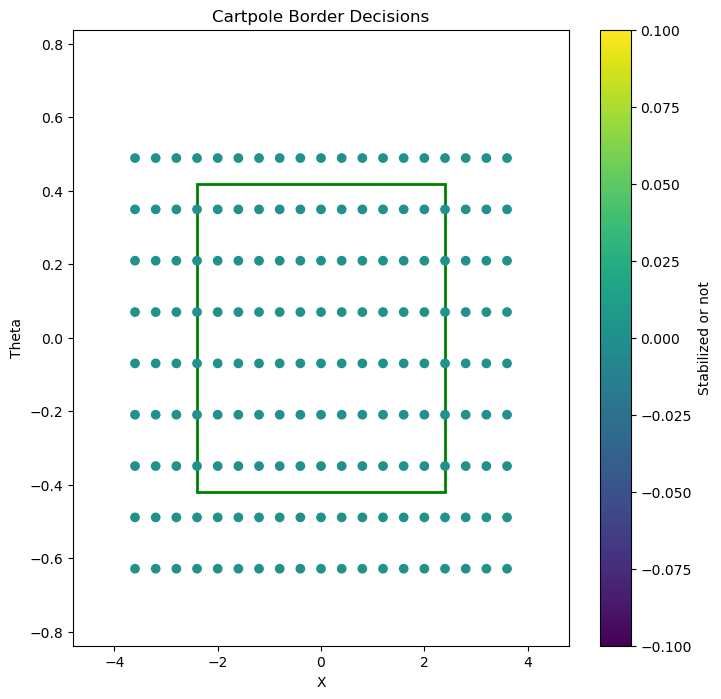

In [59]:
# initialize network
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        options =  {"state": np.array([x,0,theta,0])}
        o , info = envs.reset(options = options)
        o = torch.tensor(o, dtype=torch.float32)
        steps = 0
        done = False
        while not done and steps <=2000:
            a, _,_ = actor.get_action(o)
            a = a.detach().numpy()
            a = a.reshape(1,-1)
            next_o, r, d,terminated, info = envs.step(a)
            done = d or terminated
            steps +=1
            o = next_o
            o = torch.tensor(o, dtype=torch.float32)
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues

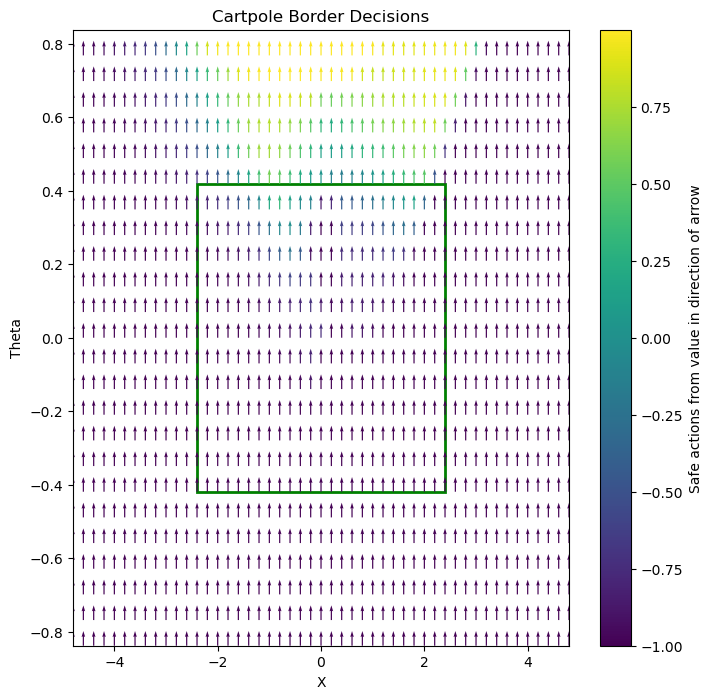

In [60]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=torch.tensor([[x,0,theta,0]], dtype=torch.float32)
        actions, _, _ = actor.get_action(o)
        a_h,b_h = actions[0]
        borders.append([x,theta])
        a_h = a_h.detach().numpy()
        b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()